## Setup Models

In [ ]:
from langchain_openai import AzureChatOpenAI

import os

#Setup the environment variables
os.environ["AZURE_OPENAI_API_KEY"]="4e4ab31800a64ae892cbb768fe28c0fc"
os.environ["AZURE_OPENAI_ENDPOINT"]="https://agentic-ai-course-kumaran.openai.azure.com/"

#Setup the LLM
model = AzureChatOpenAI(
    azure_deployment="gpt-4o" ,
    api_version="2023-03-15-preview",
    model="gpt-4o"
)


## 04.03. Setup tools for custom Agent

In [17]:
import pandas as pd

#Load the laptop product orders CSV into a Pandas dataframe.
product_orders_df = pd.read_csv("./data/laptop orders.csv")
print(product_orders_df)

   Order ID Product Ordered  Quantity Ordered Delivery Date
0  ORD-8276   SpectraBook S                 3    2024-10-16
1  ORD-6948    OmegaPro G17                 3    2024-10-25
2  ORD-7311   NanoEdge Flex                 2    2024-10-19
3  ORD-4633    OmegaPro G17                 2    2024-10-15
4  ORD-2050      GammaAir X                 2    2024-10-26


In [18]:
from langchain_core.tools import tool

@tool
def get_order_details(order_id:str) -> str :
    """
    This function returns details about a laptop order, given an order ID
    It performs an exact match between the input order id and available order ids
    If a match is found, it returns products (laptops) ordered, quantity ordered and delivery date.
    If there is NO match found, it returns -1
    """
    #Filter Dataframe for order ID
    match_order_df = product_orders_df[
                        product_orders_df["Order ID"] == order_id ]

    #Check if a record was found, if not return -1
    if len(match_order_df) == 0 :
        return -1
    else:
        return match_order_df.iloc[0].to_dict()

#Test the tool. Before running the test, comment the @tool annotation
#print(get_order_details("ORD-6948"))
#print(get_order_details("ORD-9999"))

@tool
def update_quantity(order_id:str, new_quantity:int) -> bool :
    """
    This function updates the quantity of products ( laptops ) ordered for a given order Id.
    It there are no matching orders, it returns False.
    """
    #Find if matching record exists
    match_order_df = product_orders_df[
                        product_orders_df["Order ID"] == order_id ]

    #Check if a record was found, if not return -1
    if len(match_order_df) == 0 :
        return -1
    else:
        product_orders_df.loc[
            product_orders_df["Order ID"] == order_id, 
                "Quantity Ordered"] = new_quantity
        return True
        
#Test the tool. Before running the test, comment the @tool annotation
#print(get_order_details("ORD-6948"))
#print(update_quantity("ORD-6948", 1))
#print(get_order_details("ORD-6948"))
#print(update_quantity("ORD-9999",2))
#print(product_orders_df)

## 04.04. Setup the Custom Orders Agent

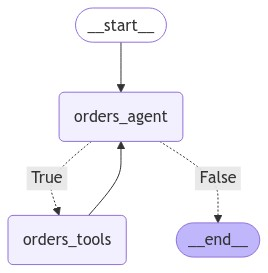

In [ ]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from IPython.display import Image
import json

#An Agent State class that keep state of the agent while it answers a query
class OrdersAgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

#-----------------------------------------------------------------------------
#An agent class that manages all agentic interactions
class OrdersAgent:

    #Setup the agent graph, tools and memory
    def __init__(self, model, tools, system_prompt, debug):
        
        self.system_prompt=system_prompt
        self.debug=debug

        #Setup the graph for the agent manually
        agent_graph=StateGraph(OrdersAgentState)
        agent_graph.add_node("orders_llm",self.call_llm)
        agent_graph.add_node("orders_tools",self.call_tools)
        agent_graph.add_conditional_edges(
            "orders_llm",
            self.is_tool_call,
            {True: "orders_tools", False: END }
        )
        agent_graph.add_edge("orders_tools","orders_llm")
        #Set where there graph starts
        agent_graph.set_entry_point("orders_llm")

        #Add chat memory
        self.memory=MemorySaver()
        #compile the graph
        self.agent_graph = agent_graph.compile(checkpointer=self.memory)

        #Setup tools
        self.tools = { tool.name : tool for tool in tools }
        if self.debug:
            print("\nTools loaded :", self.tools)
            
        #attach tools to model
        self.model=model.bind_tools(tools)


    #Call the LLM with the messages to get next action/result
    def call_llm(self, state:OrdersAgentState):
        
        messages=state["messages"]

        #If system prompt exists, add to messages in the front
        if self.system_prompt:
            messages = [SystemMessage(content=self.system_prompt)] + messages
            
        #invoke the model with the message history
        result = self.model.invoke(messages)
        if self.debug:
            print(f"\nLLM Returned : {result}")
        #Return the LLM output
        return { "messages":[result] }
    
    
    #Check if the next action is a tool call.
    def is_tool_call(self, state:OrdersAgentState):
        last_message = state["messages"][-1]
        #print("Last result from LLM : ", last_message)
        #If tool action is requested
        if len(last_message.tool_calls) > 0 :
            return True
        else:
            return False

    #Execute the tool requested with the given parameters
    def call_tools(self, state:OrdersAgentState):
        #Get last message
        tool_calls = state["messages"][-1].tool_calls
        results=[]

        #Multiple tool calls may be requested. Execute one by one
        for tool in tool_calls:
            #Handle tool missing error
            if not tool["name"] in self.tools:
                print(f"Unknown tool name {tool}")
                result = "Invalid tool found. Please retry"
            else:
                #Call the tool and collect results
                result=self.tools[tool["name"]].invoke(tool["args"])

            #append results to the list of tool results
            results.append(ToolMessage(tool_call_id=tool['id'], 
                                       name=tool['name'], 
                                       content=str(result)))

            if self.debug:
                print(f"\nTools returned {results}")
            #return tool results
            return { "messages" : results }

#-----------------------------------------------------------------------------
#Setup the custom agent

#Note that this is a string, since the model init only accepts a string.
system_prompt = """
    You are professional chatbot that manages orders for laptops sold by our company.
    The tools allow for retrieving order details as well as update order quantity.
    Do NOT reveal information about other orders than the one requested.
    You will handle small talk and greetings by producing professional responses.
    """

#Create the custom orders agent
orders_agent = OrdersAgent(model, 
                           [get_order_details, update_quantity], 
                           system_prompt,
                           debug=False)

#Visualize the Agent
Image(orders_agent.agent_graph.get_graph().draw_mermaid_png())
        

## 04.05 Setup and execute the Orders Chatbot

In [43]:
import uuid
#Send a sequence of messages to chatbot and get its response
#This simulates the conversation between the user and the Agentic chatbot
user_inputs = [
    "How are you doing?",
    "Please show me the details of the order ORD-7311",
    "Can you add one more of that laptop to the order? ",
    "Can you show me the details again ? ",
    "What about order ORD-9999 ?",
    "Bye"
]

#Create a new thread
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

for input in user_inputs:
    print(f"----------------------------------------\nUSER : {input}")
    #Format the user message
    user_message = {"messages":[HumanMessage(input)]}
    #Get response from the agent
    ai_response = orders_agent.agent_graph.invoke(user_message,config=config)
    #Print the response
    print(f"\nAGENT : {ai_response['messages'][-1].content}")

----------------------------------------
USER : How are you doing?

AGENT : I'm doing great, thank you! How can I assist you with your laptop order today?
----------------------------------------
USER : Please show me the details of the order ORD-7311

AGENT : Here are the details for your order with ID **ORD-7311**:
- **Product Ordered:** NanoEdge Flex
- **Quantity Ordered:** 6
- **Delivery Date:** 2024-10-19

Is there anything else I can assist you with regarding this order?
----------------------------------------
USER : Can you add one more of that laptop to the order? 

AGENT : The quantity for your order **ORD-7311** has been successfully updated to 7 units of the NanoEdge Flex laptop.

Is there anything else I can help you with?
----------------------------------------
USER : Can you show me the details again ? 

AGENT : Here are the updated details for your order with ID **ORD-7311**:
- **Product Ordered:** NanoEdge Flex
- **Quantity Ordered:** 7
- **Delivery Date:** 2024-10-19